<a href="https://colab.research.google.com/github/n-erfan/roboflow/blob/main/football_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Configure API keys from [`HuggingFace Settings`](https://huggingface.co/settings) and [`Roboflow Settings`](https://app.roboflow.com/settings/api).

Ensure GPU Acceleration

In [2]:
!nvidia-smi

Sun Sep 29 05:46:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Install Dependencies

In [4]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
!pip install -q git+https://github.com/roboflow/sports.git
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 MB 5.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-gpu 0.21.0 requires onnxruntime-gpu<=1.15.1, but you have onnxruntime-gpu 1.18.0 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.1 MB/s eta 0:00:00
Found existing installation: supervision 0.22.0
Uninstalling supervision-0.22.0:
  Successfully uninstalled supervision-0.22.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-gpu 0.21.0 requires onnxruntime-gpu<=1.15.1, but you have onnxruntime-gpu 1.18.0 which is incompatible.
inference-gpu 0.

Using sample videos from the [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout).

In [8]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 136MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
From (redirected): https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf&confirm=t&uuid=ffd05e29-8d56-468d-86bd-e2863b65114c
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 145MB/s] 


Show a single Frame

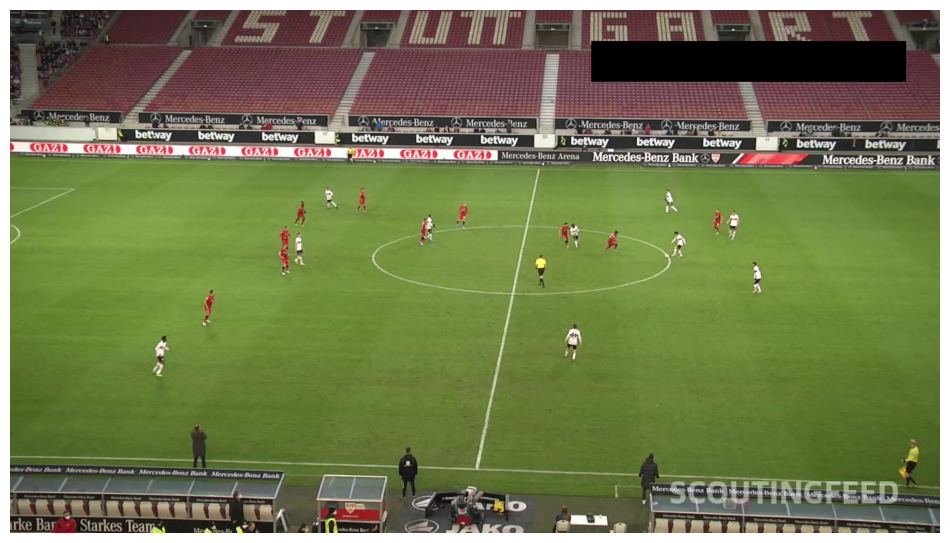

In [13]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/0bfacc_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

Detecting Players and the Referee

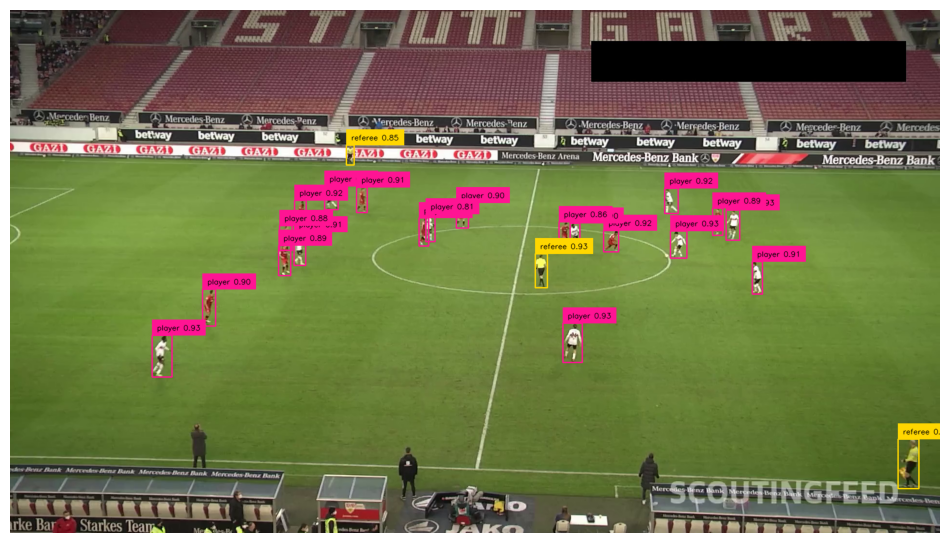

In [37]:
# Using box annotation
from tqdm import tqdm
import supervision as sv

SOURCE_VIDEO_PATH = "/content/0bfacc_0.mp4"

# annotate in boxes
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

# annotate with labels players/gk/ref along with conf levels
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info) #allows save video along with info

#loop over frames of the video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)


result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

Environment Creation

In [7]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

Get Pre-Trained Model for Detection

In [9]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


## Teams Splitting Algorithm

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-team-clustering.png)

In [12]:
from tqdm import tqdm
import supervision as sv

SOURCE_VIDEO_PATH = "/content/0bfacc_0.mp4"
PLAYER_ID = 2
STRIDE = 30 # to skip every 29 frames

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc="get  crops"):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

get  crops: 25it [00:13,  1.85it/s]


Cropped Images of players

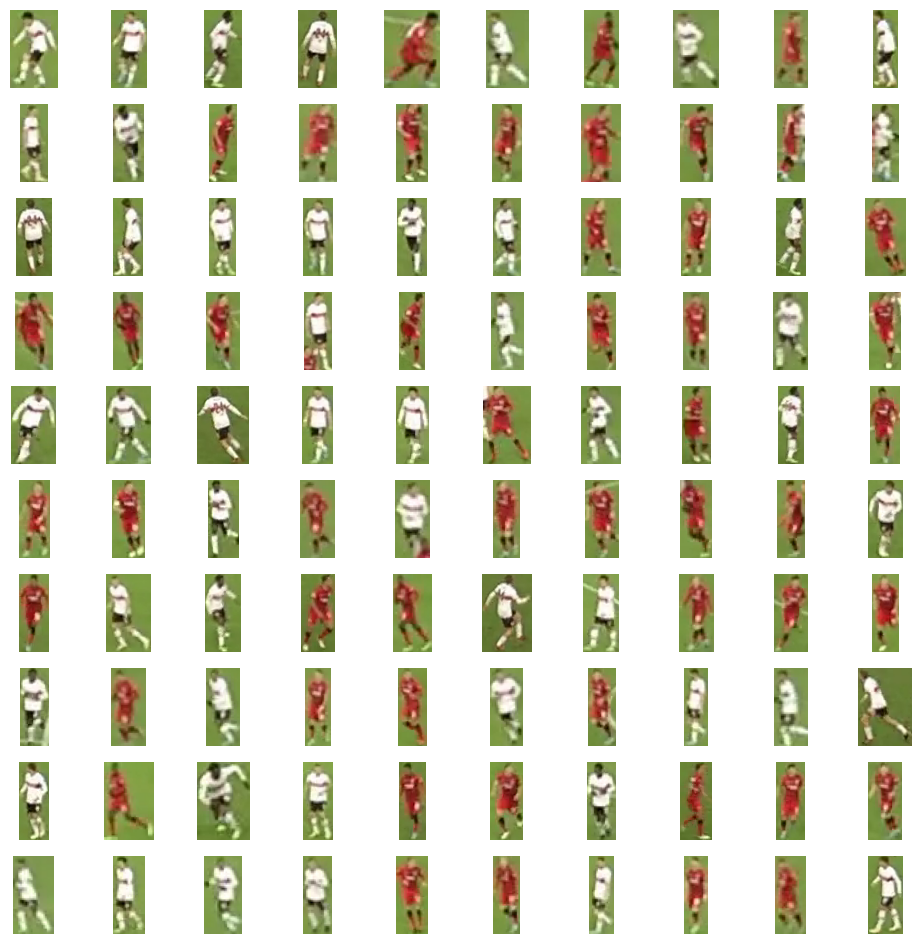

In [14]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10)) # to show 100/478

Using [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) to calculate embeddings for each of the crops.

In [15]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [16]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE) # to get batches from the crops
data = []
with torch.no_grad():
  for batch in tqdm(batches, desc='embedding extraction'):
    inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
    outputs = EMBEDDINGS_MODEL(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
    data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 16it [00:08,  1.88it/s]


Using [UMAP](https://github.com/lmcinnes/umap) to project the embeddings from (N, 768) to (N, 3) and then perform a two-cluster division using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [18]:
import umap
from sklearn.cluster import KMeans # kmeans clustering algo

REDUCER = umap.UMAP(n_components=3) # to reduce dim from 768 to 3
CLUSTERING_MODEL = KMeans(n_clusters=2)

projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [19]:
# divide into teams
team_0 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster == 0
    ]

team_1 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster == 1
]

In [20]:
# team 0
sv.plot_images_grid(team_0[:100], grid_size=(10, 10))

In [21]:
# team 1
sv.plot_images_grid(team_1[:100], grid_size=(10, 10))

Using the SigLIP, UMAP, and KMeans comb package: [TeamClassifier](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/common/team.py#L41) present in the [sports](https://github.com/roboflow/sports) repository.

In [30]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/0bfacc_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:16,  1.48it/s]
Embedding extraction: 19it [00:07,  2.65it/s]


Goalkeeper Position Heuristic Function

In [31]:
def resolve_goalkeepers_team_id(players: sv.Detections, goalkeepers: sv.Detections) -> np.ndarray:
  goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
  players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
  team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
  team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
  goalkeepers_team_id = []
  for goalkeeper_xy in goalkeepers_xy:
      dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
      dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
      goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

  return np.array(goalkeepers_team_id)

Player, Ball and Referee Tracking

  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.17it/s]
  0%|          | 1/750 [00:02<33:35,  2.69s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.97it/s]
  0%|          | 2/750 [00:05<33:23,  2.68s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.25it/s]
  0%|          | 3/750 [00:08<36:04,  2.90s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.04it/s]
  1%|          | 4/750 [00:12<43:29,  3.50s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.24it/s]
  1%|          | 5/750 [00:15<40:14,  3.24s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.53it/s]
  1%|          | 6/750 [00:19<43:58,  3.55s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
  1%|          | 7/750 [00:25<54:18,  4.39s/it]
Embedding extraction: 

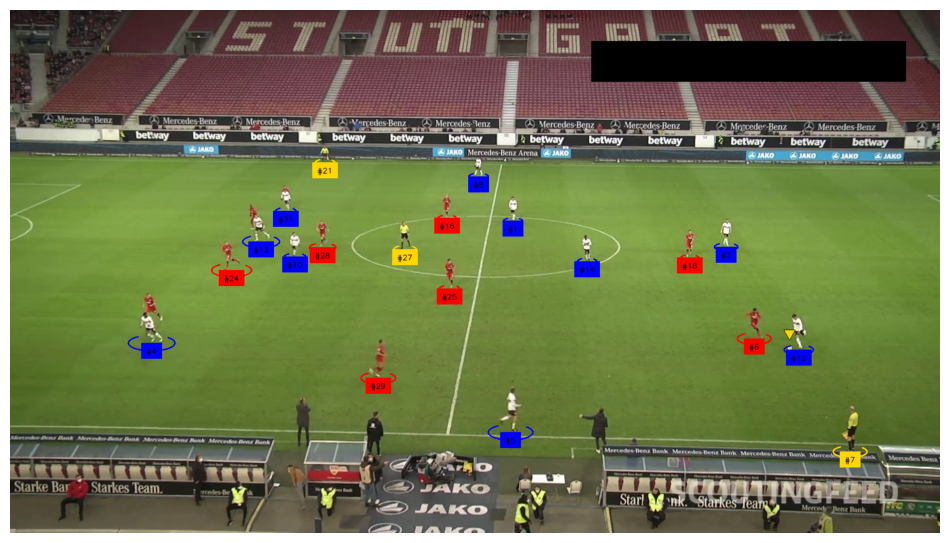

In [35]:
SOURCE_VIDEO_PATH = "/content/0bfacc_0.mp4"
TARGET_VIDEO_PATH = "/content/0bfacc_0_result_1.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
STRIDE = 10

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#0000FF', '#FF0000', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#0000FF', '#FF0000', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info) #to save video along with info

#loop over frames of the video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

with video_sink:
  for frame in tqdm(frame_generator, total = video_info.total_frames):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)

    referees_detections.class_id -= 1

    all_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections])

    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)
    video_sink.write_frame(annotated_frame) # pass the currently processed frame into the video

sv.plot_image(annotated_frame)